# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [22]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [23]:
# pip install numpy==1.26.4dd


In [2]:
# Import essential libraries
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, metrics
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd # Import pandas for DataFrame creation


Load the dataset.

In [25]:
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('waste_data')

## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [26]:
# Create a function to load the raw images
def get_image_paths_and_labels(base_dir):
    paths, labels = [], []
    for label in sorted(os.listdir(base_dir)):
        label_dir = os.path.join(base_dir, label)
        if not os.path.isdir(label_dir):
            continue
        for file in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file)
            if os.path.isfile(file_path):
                paths.append(file_path)
                labels.append(label)
    return paths, labels




#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [27]:
# Get the images and their labels

base_dir = "waste_data/data"
image_paths, labels = get_image_paths_and_labels(base_dir)

print(f"Total images: {len(image_paths)}")
print(f"Classes: {sorted(set(labels))}")

Total images: 7625
Classes: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

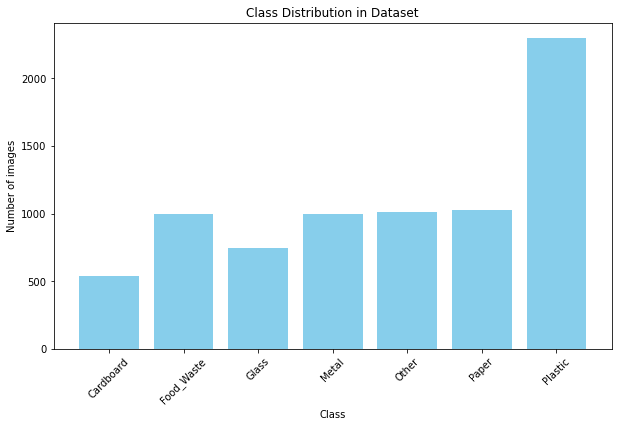

  Class Label  Image Count  Percentage (%)
0   Cardboard          540            7.08
1  Food_Waste         1000           13.11
2       Glass          750            9.84
3       Metal         1000           13.11
4       Other         1010           13.25
5       Paper         1030           13.51
6     Plastic         2295           30.10


In [28]:
# Visualise Data Distribution


from collections import Counter

# Count occurrences of each class in the dataset
class_counts = Counter(labels)

# Extract class names and counts
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Plot
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Class Distribution in Dataset')
plt.xticks(rotation=45)
plt.show()

import pandas as pd


# Get total number of images
total_images = sum(class_counts.values())

# Create a DataFrame
class_distribution_df = pd.DataFrame({
    'Class Label': class_counts.keys(),
    'Image Count': class_counts.values(),
})

# Add percentage column
class_distribution_df['Percentage (%)'] = (
    class_distribution_df['Image Count'] / total_images * 100).round(2)

# Sort by class name (optional)
class_distribution_df = class_distribution_df.sort_values('Class Label').reset_index(drop=True)

# Display the table
print(class_distribution_df)


Processed 1000/7625 images...
Processed 2000/7625 images...
Processed 3000/7625 images...
Processed 4000/7625 images...
Processed 5000/7625 images...
Processed 6000/7625 images...
Processed 7000/7625 images...
Dimension collection complete.
Total images processed: 7625


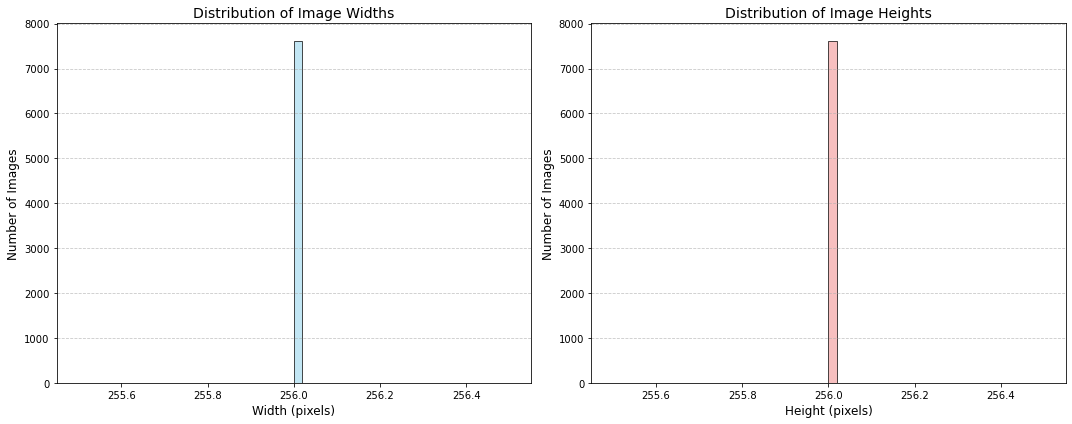

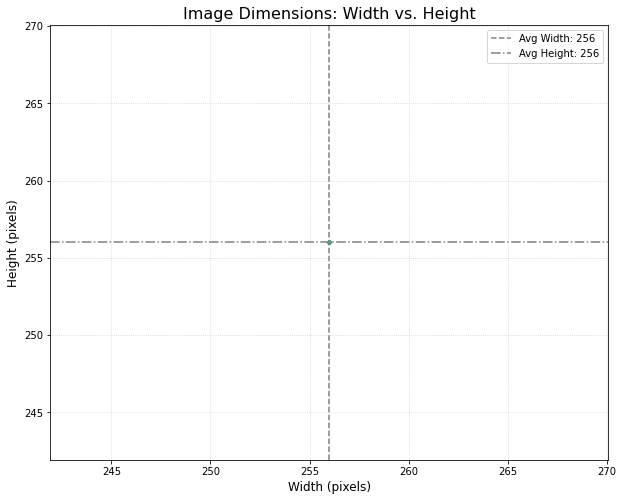

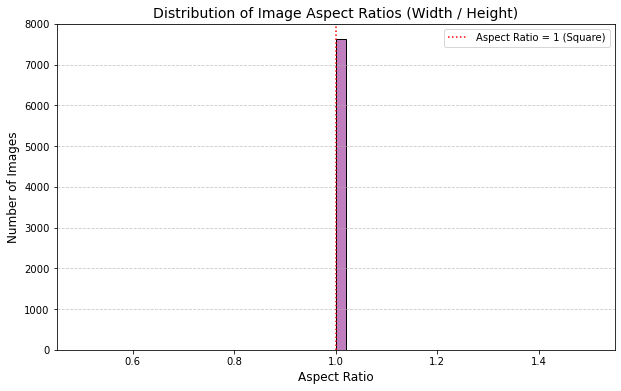

In [48]:
#plotting histograms of image widths and heights, creating a scatter plot of width vs. height, 
#and visualizing the distribution of aspect ratios.


# --- 1. Collect Image Dimensions and Handle Errors ---
def collect_image_dimensions(image_paths):
    
    image_widths = []
    image_heights = []
    corrupted_images_count = 0

    print("Collecting image dimensions...")
    for i, path in enumerate(image_paths):
        try:
            with Image.open(path) as img:
                image_widths.append(img.width)
                image_heights.append(img.height)
        except Exception as e:
            corrupted_images_count += 1
         
        
       
        if (i + 1) % 1000 == 0:
            print(f"Processed {i + 1}/{len(image_paths)} images...")

    if corrupted_images_count > 0:
        print(f"Warning: Skipped {corrupted_images_count} corrupted or unreadable images.")
    print("Dimension collection complete.")
    return image_widths, image_heights


if 'image_paths' not in locals() and 'image_paths' not in globals():
    print("WARNING: 'image_paths' variable not found. Using dummy data for demonstration.")
    
    import random
    dummy_widths = [random.randint(50, 1000) for _ in range(500)]
    dummy_heights = [random.randint(50, 1000) for _ in range(500)]
    image_widths = dummy_widths
    image_heights = dummy_heights
else:
    image_widths, image_heights = collect_image_dimensions(image_paths)


# Ensure we have data before plotting
if not image_widths or not image_heights:
    print("No image dimensions collected. Please ensure 'image_paths' is correctly populated and images are readable.")
else:
    print(f"Total images processed: {len(image_widths)}")

    # --- 2. Plot Histograms of Widths and Heights ---
    plt.figure(figsize=(15, 6))

    # Histogram for Image Widths
    plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
    sns.histplot(image_widths, bins=50, kde=True, color='skyblue')
    plt.title('Distribution of Image Widths', fontsize=14)
    plt.xlabel('Width (pixels)', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Histogram for Image Heights
    plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
    sns.histplot(image_heights, bins=50, kde=True, color='lightcoral')
    plt.title('Distribution of Image Heights', fontsize=14)
    plt.xlabel('Height (pixels)', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plt.show()

    # --- 3. Create a Scatter Plot of Width vs. Height ---
    plt.figure(figsize=(10, 8))
    plt.scatter(image_widths, image_heights, alpha=0.6, s=10, color='mediumseagreen') # s is marker size
    plt.title('Image Dimensions: Width vs. Height', fontsize=16)
    plt.xlabel('Width (pixels)', fontsize=12)
    plt.ylabel('Height (pixels)', fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.axvline(np.mean(image_widths), color='gray', linestyle='--', label=f'Avg Width: {np.mean(image_widths):.0f}')
    plt.axhline(np.mean(image_heights), color='gray', linestyle='-.', label=f'Avg Height: {np.mean(image_heights):.0f}')
    plt.legend()
    plt.show()

    # --- 4. Plot the Distribution of Aspect Ratios ---
    # Calculate aspect ratios (handle division by zero for height if any exist, though unlikely for valid images)
    aspect_ratios = []
    for h, w in zip(image_heights, image_widths):
        if h != 0: # Ensure height is not zero to avoid ZeroDivisionError
            aspect_ratios.append(w / h)
        else:
            aspect_ratios.append(np.nan) # Append NaN for images with zero height

    # Remove NaN values before plotting if any were introduced
    aspect_ratios = [ar for ar in aspect_ratios if not np.isnan(ar)]

    plt.figure(figsize=(10, 6))
    sns.histplot(aspect_ratios, bins=50, kde=True, color='purple')
    plt.title('Distribution of Image Aspect Ratios (Width / Height)', fontsize=14)
    plt.xlabel('Aspect Ratio', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.axvline(1.0, color='red', linestyle=':', label='Aspect Ratio = 1 (Square)')
    plt.legend()
    plt.show()


-  Distribution of Image Widths and Heights:This indicates that nearly all images in the dataset have a width of approximately 256 pixels and a height of approximately 256 pixels. 
    There's very little variation in the dimensions.
    
- Image Dimensions: Width vs. Height Scatter Plot: This plot visually confirms that the vast majority,
   if not all, of the images are square and have dimensions of 256x256 pixels.
- Distribution of Image Aspect Ratios (Width / Height):This confirms that all images in your dataset are perfectly square, 
    as their width divided by their height consistently results in 1.0.

Processed 500/500 sample images...
Pixel data collection complete.


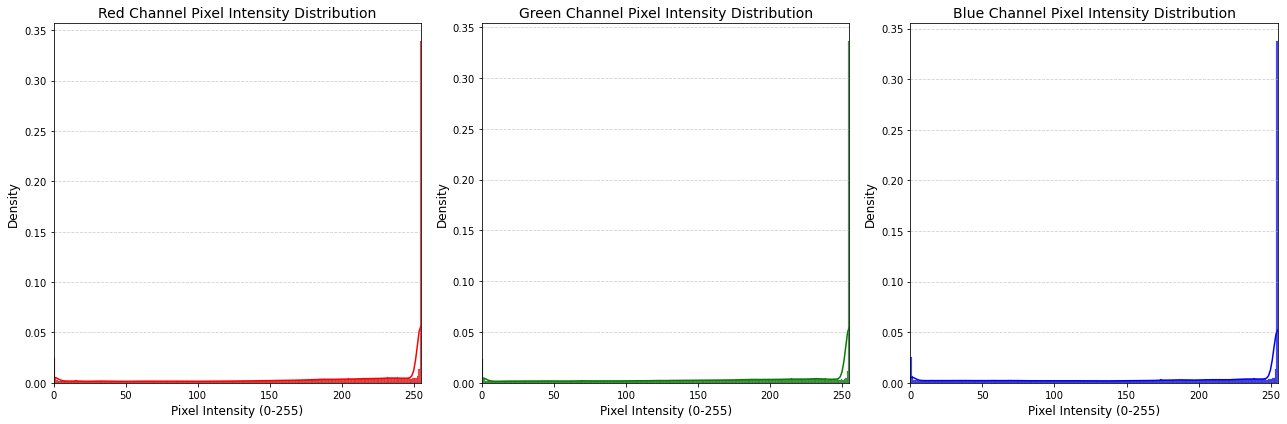


--- Summary Statistics for RGB Channels ---
Red Channel: Mean=186.59, Std Dev=81.18
Green Channel: Mean=181.51, Std Dev=81.57
Blue Channel: Mean=175.63, Std Dev=87.10


In [30]:
# --- 1. Collect Pixel Data for RGB Channels ---
def collect_rgb_pixel_data(image_paths, sample_size=None):
  
    all_red_pixels = []
    all_green_pixels = []
    all_blue_pixels = []
    
    images_to_process = image_paths
    if sample_size and len(image_paths) > sample_size:
  
        import random
        images_to_process = random.sample(image_paths, sample_size)
        print(f"Collecting RGB pixel data from a sample of {sample_size} images...")
    else:
        print("Collecting RGB pixel data from all images...")

    corrupted_images_count = 0
    for i, path in enumerate(images_to_process):
        try:
            # Open image and convert to RGB to ensure 3 channels
            with Image.open(path).convert('RGB') as img:
                img_array = np.array(img) # Convert PIL image to numpy array
                
                # Flatten the 2D channel data into 1D for histogram plotting
                all_red_pixels.extend(img_array[:, :, 0].flatten())
                all_green_pixels.extend(img_array[:, :, 1].flatten())
                all_blue_pixels.extend(img_array[:, :, 2].flatten())
        except Exception as e:
            corrupted_images_count += 1
            # print(f"Error processing image {path}: {e}") # Uncomment to see specific errors
        
        # Optional: Print progress for large datasets
        if (i + 1) % 500 == 0:
            print(f"Processed {i + 1}/{len(images_to_process)} sample images...")

    if corrupted_images_count > 0:
        print(f"Warning: Skipped {corrupted_images_count} corrupted or unreadable images during pixel collection.")
    print("Pixel data collection complete.")

    return np.array(all_red_pixels), np.array(all_green_pixels), np.array(all_blue_pixels)


if 'image_paths' not in locals() and 'image_paths' not in globals():
    print("WARNING: 'image_paths' variable not found. Using dummy data for demonstration.")
    # Create some dummy pixel data to simulate real image data for plotting
    num_dummy_pixels = 500000 # Simulate a large number of pixels from many images
    red_pixels = np.random.randint(0, 256, num_dummy_pixels)
    green_pixels = np.random.randint(0, 256, num_dummy_pixels)
    blue_pixels = np.random.randint(0, 256, num_dummy_pixels)
else:
    
    sample_size_for_histograms = min(len(image_paths), 500) # Adjusted for faster execution
    red_pixels, green_pixels, blue_pixels = collect_rgb_pixel_data(image_paths, sample_size=sample_size_for_histograms)


# Ensure we have data before plotting
if red_pixels.size == 0 or green_pixels.size == 0 or blue_pixels.size == 0:
    print("No pixel data collected. Cannot plot histograms.")
else:
    # --- 2. Plot Histograms for RGB Channels ---
    plt.figure(figsize=(18, 6)) # Adjust figure size for better visualization

    # Red Channel Histogram
    plt.subplot(1, 3, 1) # 1 row, 3 columns, 1st plot
    sns.histplot(red_pixels, bins=256, color='red', kde=True, stat='density', alpha=0.7)
    plt.title('Red Channel Pixel Intensity Distribution', fontsize=14)
    plt.xlabel('Pixel Intensity (0-255)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.xlim(0, 255) # Ensure x-axis covers the full 0-255 range
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Green Channel Histogram
    plt.subplot(1, 3, 2) # 1 row, 3 columns, 2nd plot
    sns.histplot(green_pixels, bins=256, color='green', kde=True, stat='density', alpha=0.7)
    plt.title('Green Channel Pixel Intensity Distribution', fontsize=14)
    plt.xlabel('Pixel Intensity (0-255)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.xlim(0, 255)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Blue Channel Histogram
    plt.subplot(1, 3, 3) # 1 row, 3 columns, 3rd plot
    sns.histplot(blue_pixels, bins=256, color='blue', kde=True, stat='density', alpha=0.7)
    plt.title('Blue Channel Pixel Intensity Distribution', fontsize=14)
    plt.xlabel('Pixel Intensity (0-255)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.xlim(0, 255)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plt.show()

    # --- Optional: Calculate Mean and Standard Deviation for each channel ---
    print("\n--- Summary Statistics for RGB Channels ---")
    print(f"Red Channel: Mean={np.mean(red_pixels):.2f}, Std Dev={np.std(red_pixels):.2f}")
    print(f"Green Channel: Mean={np.mean(green_pixels):.2f}, Std Dev={np.std(green_pixels):.2f}")
    print(f"Blue Channel: Mean={np.mean(blue_pixels):.2f}, Std Dev={np.std(blue_pixels):.2f}")



The images are generally bright with a strong lean towards high pixel intensity values, especially for the red channel, 
and a relative scarcity of mid-range pixel intensities. 
This information is valuable for understanding your dataset's characteristics and for making informed decisions about 
preprocessing and model design.

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

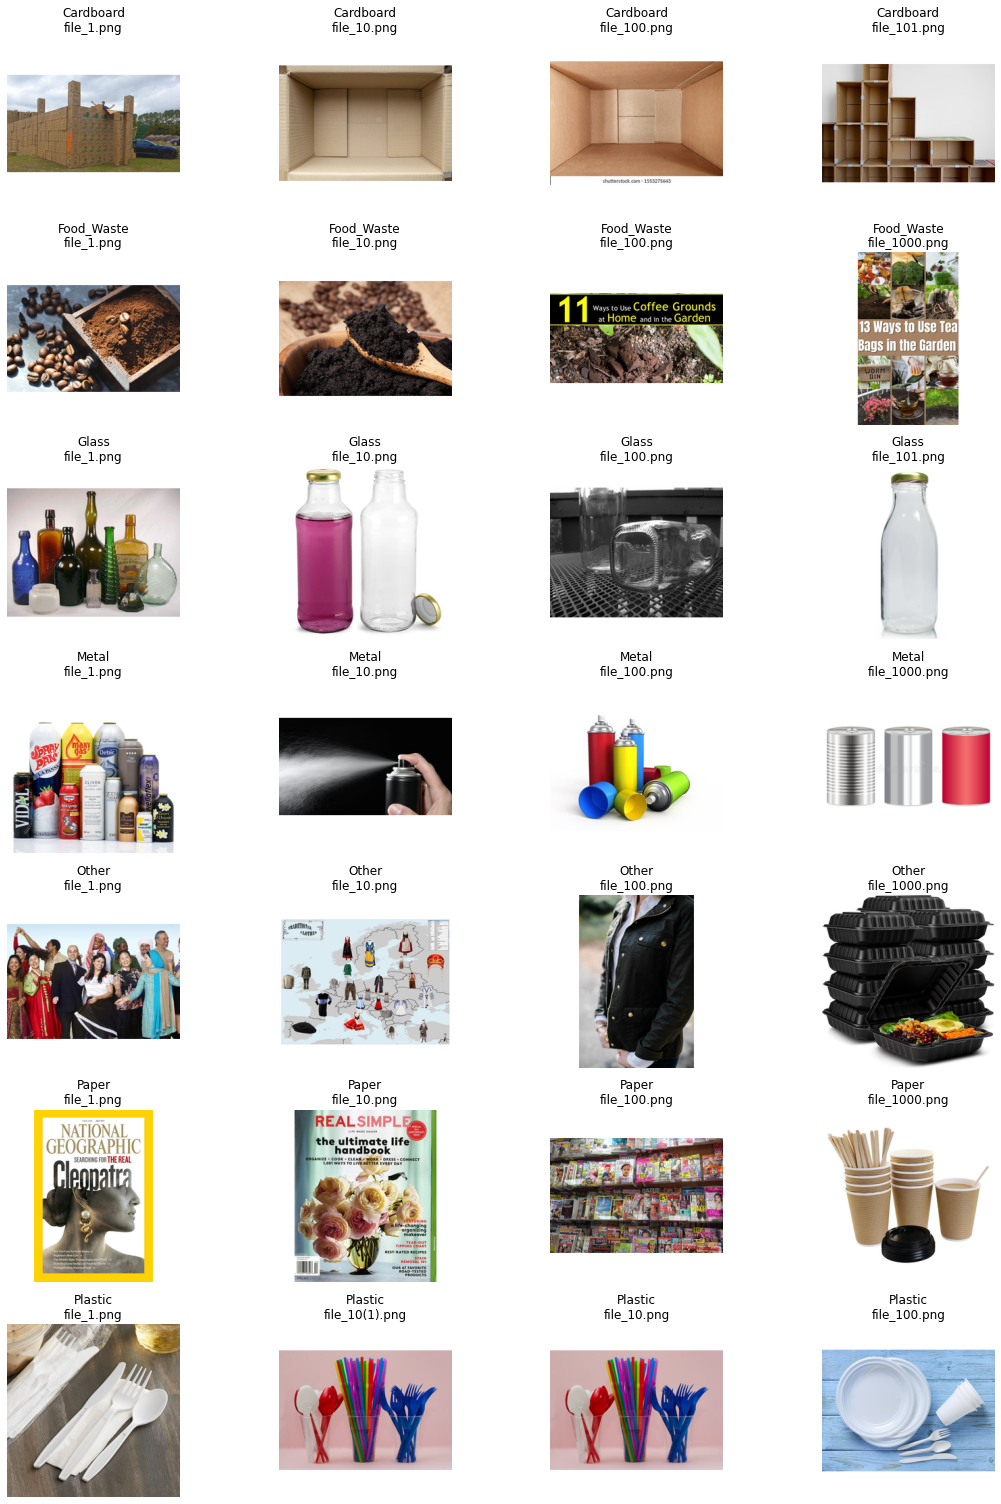

In [32]:
# Visualise Sample Images (across different labels)
from collections import defaultdict
def show_samples_with_paths(image_paths, labels, samples_per_class=2):
    from PIL import Image

    label_to_images = defaultdict(list)
    for path, label in zip(image_paths, labels):
        if len(label_to_images[label]) < samples_per_class:
            try:
                img = Image.open(path).convert('RGB')
                label_to_images[label].append((img, path))
            except Exception as e:
                print(f"Error loading image {path}: {e}")

    total_classes = len(label_to_images)
    plt.figure(figsize=(samples_per_class * 4, total_classes * 3))

    i = 1
    for label, img_list in label_to_images.items():
        for img, path in img_list:
            plt.subplot(total_classes, samples_per_class, i)
            plt.imshow(img)
            fname = os.path.basename(path)
            plt.title(f"{label}\n{fname}")
            plt.axis('off')
            i += 1

    plt.tight_layout()
    plt.show()

show_samples_with_paths(image_paths, labels, samples_per_class=4)

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [33]:
# Find the smallest and largest image dimensions from the data set

from PIL import Image

def find_image_size_extremes(folder_path):
    min_width, min_height = float('inf'), float('inf')
    max_width, max_height = 0, 0

    for class_folder in sorted(os.listdir(folder_path)):
        class_path = os.path.join(folder_path, class_folder)
        if not os.path.isdir(class_path):
            continue
        for file in os.listdir(class_path):
            file_path = os.path.join(class_path, file)
            try:
                with Image.open(file_path) as img:
                    width, height = img.size
                    if width < min_width:
                        min_width = width
                    if height < min_height:
                        min_height = height
                    if width > max_width:
                        max_width = width
                    if height > max_height:
                        max_height = height
            except Exception as e:
                print(f"Error opening {file_path}: {e}")

    return (min_width, min_height), (max_width, max_height)

base_dir = "waste_data/data"  # Your dataset folder
smallest_dim, largest_dim = find_image_size_extremes(base_dir)

print(f"Smallest image dimensions (WxH): {smallest_dim}")
print(f"Largest image dimensions (WxH): {largest_dim}")

Smallest image dimensions (WxH): (256, 256)
Largest image dimensions (WxH): (256, 256)


In [34]:
# Resize the image dimensions
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),                 # Mirror the object
    layers.RandomRotation(0.1),                      # Rotate slightly (±10%)
    layers.RandomZoom(0.1),                          # Slight zoom in/out
    layers.RandomTranslation(0.1, 0.1),              # Small shift
])

def process_image(file_path, label, augment=False):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)
    if augment:
        img = data_augmentation(img)

    return img, label

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

#### **2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [35]:
# Encode the labels suitably

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
class_names = label_encoder.classes_

### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [36]:
# Assign specified parts of the dataset to train and validation sets

# Split data
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42)

# Print dataset sizes
print(f"Number of training samples: {len(train_paths)}")
print(f"Number of test samples: {len(test_paths)}")

# Create tf.data.Dataset objects
def create_dataset(paths, labels, augment=False, shuffle=True):
    def process(file_path, label):
        return process_image(file_path, label, augment)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(process, num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# Only training data is shuffled
train_ds = create_dataset(train_paths, train_labels, augment=True, shuffle=True)
test_ds = create_dataset(test_paths, test_labels, augment=False, shuffle=False)

Number of training samples: 6100
Number of test samples: 1525


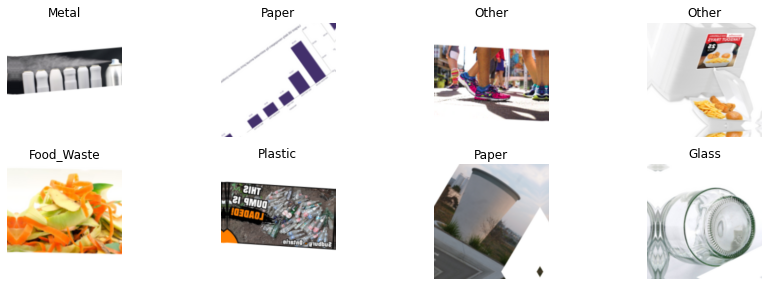

In [37]:
# Visualize Augmentations 
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 8))  

    for i in range(8):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy())
        class_idx = labels[i].numpy()
        plt.title(class_names[class_idx])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

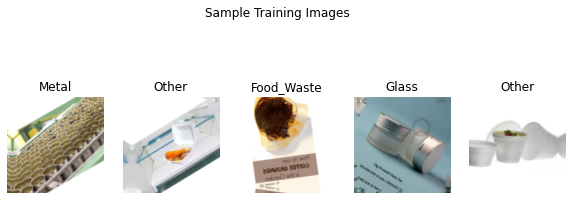

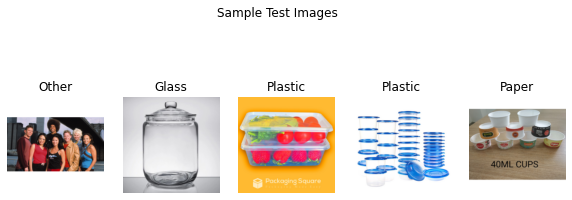

In [38]:
# Visualize a few train and test entries
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 4))
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
    plt.suptitle("Sample Training Images")
    plt.show()

for images, labels in test_ds.take(1):
    plt.figure(figsize=(10, 4))
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
    plt.suptitle("Sample Test Images")
    plt.show()

## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [40]:
# Build the first model 

num_classes = 7 
# Simple Model with only 1 Convolutional Layer
model_simple = models.Sequential([
  
    layers.Input(shape=(224, 224, 3)),
    
    # --- Single Convolutional Block ---
    # Starting with 64 filters for a decent feature extraction ability in a single layer.
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(), # Normalizes activations of the previous layer
    layers.Activation('relu'),   # Rectified Linear Unit activation
    layers.MaxPooling2D((2, 2)), # Reduces spatial dimensions, halves height and width
    layers.Dropout(0.25),        # Dropout after the convolutional block
    

    layers.Flatten(),
    
    # Fully Connected (Dense) Layers
    # Reduced units in the first Dense layer (64 units) as the feature extraction is less deep
    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),         # Dropout on the fully connected layer
    
   
    layers.Dense(num_classes, activation='softmax')
])

# Define the optimizer

optimizer_simple = optimizers.Adam() # Default learning_rate=0.001

# Compile the model
model_simple.compile(
    optimizer=optimizer_simple,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary, which shows the layers, output shapes, and number of parameters
print("--- Simple Model Summary (1 Conv Layer) ---")
model_simple.summary()



--- Simple Model Summary (1 Conv Layer) ---


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 224, 224, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 802816)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │      51,380,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,383,047 (196.01 MB)

 Trainable params: 51,382,791 (196.01 MB)

 Non-trainable params: 256 (1.00 KB)

In [42]:
#Training the model 
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1 # Added verbose to see when early stopping is triggered
)

# Define the ModelCheckpoint callback:

model_checkpoint = ModelCheckpoint(
    'best_model_1conv.keras', 
    save_best_only=True,
    monitor='val_loss',
    verbose=1 
)


callbacks = [
    early_stopping,
    model_checkpoint
]

# Train the model

print("\n--- Starting Model Training (1 Conv Layer, No LR Decay) ---")
history = model_simple.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10, # Adjusted epochs to a higher value (e.g., 25)
    callbacks=callbacks
)

print("\n--- Model Training Complete ---")





--- Starting Model Training (1 Conv Layer, No LR Decay) ---
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2331 - loss: 2.1206
Epoch 1: val_loss improved from inf to 1.82152, saving model to best_model_1conv.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.2334 - loss: 2.1196 - val_accuracy: 0.2984 - val_loss: 1.8215
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 48s/step - accuracy: 0.3367 - loss: 1.7304 
Epoch 2: val_loss improved from 1.82152 to 1.71267, saving model to best_model_1conv.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 9181s 48s/step - accuracy: 0.3368 - loss: 1.7302 - val_accuracy: 0.3475 - val_loss: 1.7127
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3602 - loss: 1.6513
Epoch 3: val_loss did not improve from 1.71267
191/191 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - accuracy: 0.3603 - loss: 1.6511 - val_accuracy: 0.3567 - val_loss: 1.8849
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4131 - loss: 1.5642
Epoch 4: val_los


Loaded the best model from: best_model_1conv.keras

--- Evaluating the Model on Test Set ---
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 241ms/step - accuracy: 0.3435 - loss: 1.7095

Test Loss: 1.7127
Test Accuracy: 0.3475

--- Classification Report ---
              precision    recall  f1-score   support

   Cardboard     0.6522    0.1389    0.2290       108
  Food_Waste     0.4060    0.6050    0.4859       200
       Glass     0.2188    0.0467    0.0769       150
       Metal     0.2287    0.5100    0.3158       200
       Other     0.2419    0.4802    0.3217       202
       Paper     0.3864    0.2476    0.3018       206
     Plastic     0.7098    0.2985    0.4202       459

    accuracy                         0.3475      1525
   macro avg     0.4063    0.3324    0.3073      1525
weighted avg     0.4488    0.3475    0.3388      1525


--- Confusion Matrix ---


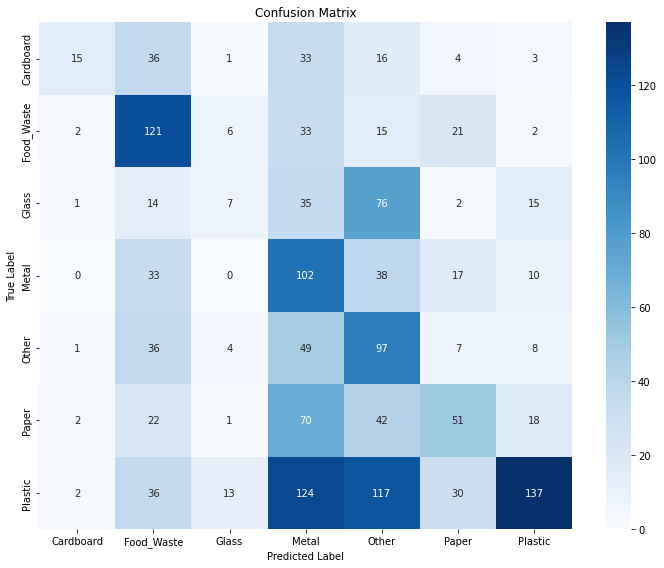

In [55]:
#Testing the model
best_model_path = 'best_model_1conv.keras'
try:
    model_for_evaluation = tf.keras.models.load_model(best_model_path)
    print(f"\nLoaded the best model from: {best_model_path}")
except Exception as e:
    print(f"Error loading model from {best_model_path}: {e}")
    print("Proceeding with the 'model' object from the training run. "
          "Ensure it's the best model if EarlyStopping's restore_best_weights was True.")
    model_for_evaluation = model # Fallback to the model object if loading fails

# --- Evaluate on the test set; display suitable metrics ---
print("\n--- Evaluating the Model on Test Set ---")
loss, accuracy = model_for_evaluation.evaluate(test_ds) 
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Collect predictions and true labels
all_preds = []
all_labels = []

# Assuming 'test_ds' iterates through (images, labels)
for imgs, lbls in test_ds:
    preds = model_for_evaluation.predict(imgs, verbose=0) 
    all_preds.extend(np.argmax(preds, axis=1))
    all_labels.extend(lbls.numpy())


# Classification Report
print("\n--- Classification Report ---")
report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names, # Make sure class_names is accessible here
    digits=4,
    zero_division=0  # handles "ill-defined precision" issue gracefully
)
print(report)

# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)
# Create DataFrame with class names as labels
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names) # Make sure class_names is accessible here

# Print cm heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

Test Loss: 1.7127

Test Accuracy: 0.3475 (or 34.75%)

Inference: This accuracy is quite low for a 7-class classification problem. A random guess would yield an accuracy of approximately 1/7≈0.14 or 14%. 
Model performs better than random, but not significantly well. The high loss also indicates that the model's predictions are far from the true labels. 
This immediately tells that this model is underperforming and needs significant improvement.

let's try another model , model 2 with 2 conv layer and better filters

In [51]:
#MODEL 2

num_classes = 7 


model2 = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    
    # --- First Convolutional Block 
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # --- Second Convolutional Block (Added for intermediate performance) ---
    layers.Conv2D(128, (3, 3), padding='same'), # Increased filters
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3), # Moderate dropout
    
    # Flatten Layer: Converts 3D feature maps to 1D feature vectors for the Dense layers
    layers.Flatten(),
    
    # Fully Connected (Dense) Layers
    layers.Dense(128), # Increased Dense units
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),
    
    # Output Layer:
    layers.Dense(num_classes, activation='softmax')
])

# Define the optimizer for model2
optimizer_model2 = optimizers.Adam(learning_rate=0.001) # Default Adam learning rate

# Compile model2
model2.compile(
    optimizer=optimizer_model2,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model2 summary
print("--- Model 2 Summary (2 Conv Layers) ---")
model2.summary()


--- Model 2 Summary (2 Conv Layers) ---


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 224, 224, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 401408)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │      51,380,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,458,183 (196.30 MB)

 Trainable params: 51,457,543 (196.29 MB)

 Non-trainable params: 640 (2.50 KB)

In [46]:
#Training the model


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1 
)

# Define the ModelCheckpoint callback:

model_checkpoint = ModelCheckpoint(
    'best_model_2conv.keras', 
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

callbacks = [
    early_stopping,
    model_checkpoint
]

# Train the model

print("\n--- Starting Model Training (2 Conv Layers, No LR Decay) ---")
history = model2.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15, # Keeping a higher number of epochs, as EarlyStopping will manage the actual stopping point.
    callbacks=callbacks
)

print("\n--- Model Training Complete ---")



--- Starting Model Training (2 Conv Layers, No LR Decay) ---
Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2855 - loss: 2.0334
Epoch 1: val_loss improved from inf to 1.89306, saving model to best_model_2conv.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 656s 3s/step - accuracy: 0.2857 - loss: 2.0325 - val_accuracy: 0.2675 - val_loss: 1.8931
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3838 - loss: 1.6575
Epoch 2: val_loss improved from 1.89306 to 1.73146, saving model to best_model_2conv.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 646s 3s/step - accuracy: 0.3838 - loss: 1.6574 - val_accuracy: 0.2734 - val_loss: 1.7315
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4234 - loss: 1.5621
Epoch 3: val_loss improved from 1.73146 to 1.48363, saving model to best_model_2conv.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 600s 3s/step - accuracy: 0.4235 - loss: 1.5620 - val_accuracy: 0.4295 - val_loss: 1.4836
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accurac


Loaded the best model from: best_model_2conv.keras

--- Evaluating the Model on Test Set (Model 2: 2 Conv Layers) ---
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 572ms/step - accuracy: 0.5096 - loss: 1.3020

Test Loss: 1.2878
Test Accuracy: 0.5266

--- Classification Report ---
              precision    recall  f1-score   support

   Cardboard     0.5789    0.7130    0.6390       108
  Food_Waste     0.6959    0.5150    0.5920       200
       Glass     0.5821    0.2600    0.3594       150
       Metal     0.4832    0.3600    0.4126       200
       Other     0.3676    0.3366    0.3514       202
       Paper     0.4306    0.4515    0.4408       206
     Plastic     0.5598    0.7647    0.6464       459

    accuracy                         0.5266      1525
   macro avg     0.5283    0.4858    0.4917      1525
weighted avg     0.5282    0.5266    0.5130      1525


--- Confusion Matrix ---


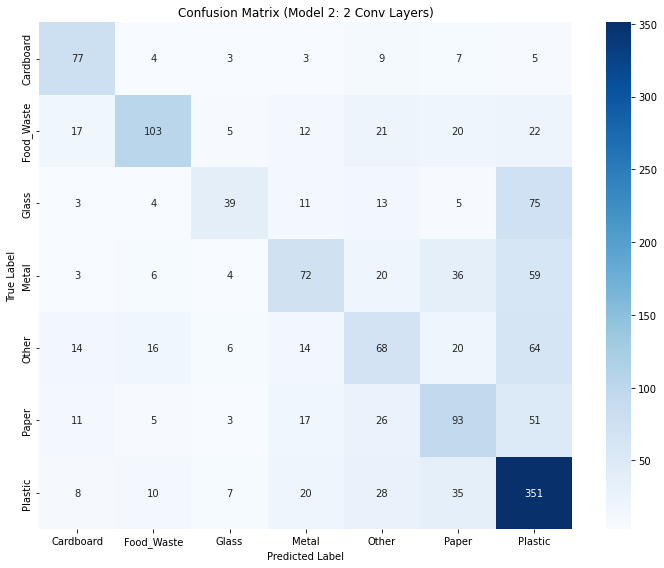

In [54]:
#test the model

# --- Load the best model saved during training ---

best_model_path = 'best_model_2conv.keras' 
try:
    model_for_evaluation = tf.keras.models.load_model(best_model_path)
    print(f"\nLoaded the best model from: {best_model_path}")
except Exception as e:
    print(f"Error loading model from {best_model_path}: {e}")

    print("Please ensure 'best_model_2conv.keras' exists and is a valid Keras model file.")



# --- Evaluate on the test set; display suitable metrics ---
print("\n--- Evaluating the Model on Test Set (Model 2: 2 Conv Layers) ---")

loss, accuracy = model_for_evaluation.evaluate(test_ds)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Collect predictions and true labels
all_preds = []
all_labels = []


for imgs, lbls in test_ds:
    preds = model_for_evaluation.predict(imgs, verbose=0)
    all_preds.extend(np.argmax(preds, axis=1))
    all_labels.extend(lbls.numpy())

# Convert lists to numpy arrays for sklearn functions
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Classification Report
print("\n--- Classification Report ---")
report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    digits=4,
    zero_division=0 
)
print(report)

# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)
# Create DataFrame with class names as labels
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Print cm heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Model 2: 2 Conv Layers)')
plt.tight_layout()
plt.show()

Overall Performance Metrics:

Test Loss: 1.2878 (Down from 1.7127 in Model 1)

Test Accuracy: 0.5266 (or 52.66%) (Up from 0.3475 in Model 1)

Inference: This is a significant improvement over Model 1! The accuracy has increased by almost 18 percentage points,
and the loss has decreased substantially. This indicates that adding a second convolutional layer and 
increasing the model's capacity was a very beneficial step. The model is now performing much better at differentiating between classes.


let's try another model with adding one more conv layer and see the results 

In [18]:
# Build and compile the model
#Final Model
model = models.Sequential([
    
    layers.Input(shape=(224, 224, 3)),
    
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),
    
    layers.Conv2D(256, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    
    layers.Dense(len(class_names), activation='softmax')
])

optimizer = optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 224, 224, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      51,380,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 51,755,911 (197.43 MB)

 Trainable params: 51,754,503 (197.43 MB)

 Non-trainable params: 1,408 (5.50 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [114]:
# Training
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True),
    reduce_lr
]

history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=15,
                    callbacks=callbacks)

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 524s 3s/step - accuracy: 0.2963 - loss: 2.0833 - val_accuracy: 0.2511 - val_loss: 2.0764 - learning_rate: 0.0010
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 672s 3s/step - accuracy: 0.3950 - loss: 1.6588 - val_accuracy: 0.3010 - val_loss: 1.8264 - learning_rate: 0.0010
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 662s 3s/step - accuracy: 0.4159 - loss: 1.5679 - val_accuracy: 0.3797 - val_loss: 1.8289 - learning_rate: 0.0010
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 575s 3s/step - accuracy: 0.4511 - loss: 1.4812 - val_accuracy: 0.4282 - val_loss: 1.6088 - learning_rate: 0.0010
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 503s 3s/step - accuracy: 0.4722 - loss: 1.3945 - val_accuracy: 0.5082 - val_loss: 1.3481 - learning_rate: 0.0010
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 527s 2s/step - accuracy: 0.4890 - loss: 1.3679 - val_accuracy: 0.3751 - val_loss: 2.0568 - learning_rate: 0.0010
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4998 - loss: 1.34

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 291ms/step - accuracy: 0.5898 - loss: 1.1509

Test Accuracy: 0.5948

 Classification Report:
               precision    recall  f1-score   support

   Cardboard     0.6783    0.7222    0.6996       108
  Food_Waste     0.6717    0.6650    0.6683       200
       Glass     0.5375    0.5733    0.5548       150
       Metal     0.7917    0.3800    0.5135       200
       Other     0.5074    0.3416    0.4083       202
       Paper     0.4065    0.6117    0.4884       206
     Plastic     0.6647    0.7386    0.6997       459

    accuracy                         0.5948      1525
   macro avg     0.6082    0.5761    0.5761      1525
weighted avg     0.6150    0.5948    0.5898      1525



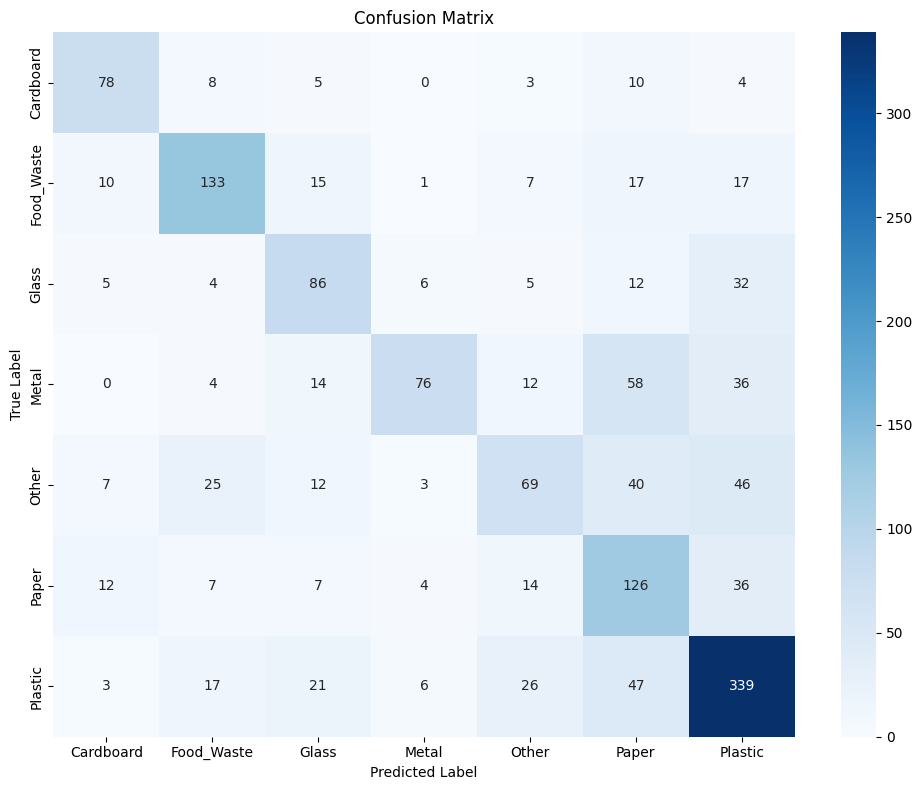

In [123]:
# Evaluate on the test set; display suitable metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate model
loss, accuracy = model.evaluate(test_ds)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Collect predictions and true labels
all_preds = []
all_labels = []

for imgs, lbls in test_ds:
    preds = model.predict(imgs, verbose=0)
    all_preds.extend(np.argmax(preds, axis=1))
    all_labels.extend(lbls.numpy())

# Classification Report
report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    digits=4,
    zero_division=0  # handles "ill-defined precision" issue gracefully
)
print("\n Classification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
# Create DataFrame with class names as labels
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

#Print cm heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


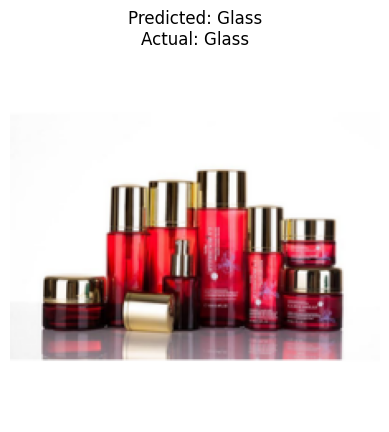

In [120]:
#Predicting a random image from validation set
import random

for images, labels in test_ds.take(1):
    idx = random.randint(0, images.shape[0] - 1)  # pick random index in the batch
    image = images[idx]
    true_label = labels[idx].numpy()

    # Expand dimensions and predict
    image_batch = tf.expand_dims(image, axis=0)
    pred_probs = model.predict(image_batch)
    pred_label = np.argmax(pred_probs, axis=1)[0]

    # Plot the image (rescale for display)
    plt.imshow((image.numpy() * 255).astype("uint8"))
    plt.axis('off')
    plt.title(f"Predicted: {class_names[pred_label]}\nActual: {class_names[true_label]}")
    plt.show()

# Transfer Learning using VGG 16

In [124]:
#Using VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load base VGG16 model (pre-trained on ImageNet)
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
base_model.trainable = False  # Freeze convolutional layers

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)     # Increased from 128 for richer representation
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax')(x)  # 7 target classes

# Create final model
model_vgg = Model(inputs=base_model.input, outputs=output)


model_vgg.compile(
    optimizer=Adam(learning_rate=1e-4),  # Slower LR for stability in TL
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_vgg.summary()


# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint("best_vgg_model.keras", monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
history_vgg = model_vgg.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15,
    callbacks=[early_stop, checkpoint]
)






Model: "functional_131"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 256)                 │         131,3

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2051 - loss: 1.9693
Epoch 1: val_loss improved from inf to 1.71251, saving model to best_vgg_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 618s 3s/step - accuracy: 0.2054 - loss: 1.9689 - val_accuracy: 0.3056 - val_loss: 1.7125
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3128 - loss: 1.7458
Epoch 2: val_loss improved from 1.71251 to 1.60188, saving model to best_vgg_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 699s 4s/step - accuracy: 0.3129 - loss: 1.7457 - val_accuracy: 0.3921 - val_loss: 1.6019
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3686 - loss: 1.6395
Epoch 3: val_loss improved from 1.60188 to 1.50980, saving model to best_vgg_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 797s 4s/step - accuracy: 0.3687 - loss: 1.6395 - val_accuracy: 0.4262 - val_loss: 1.5098
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4122 - loss: 1.5540
Epoch 4: val_loss improved from 1.50980 to 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

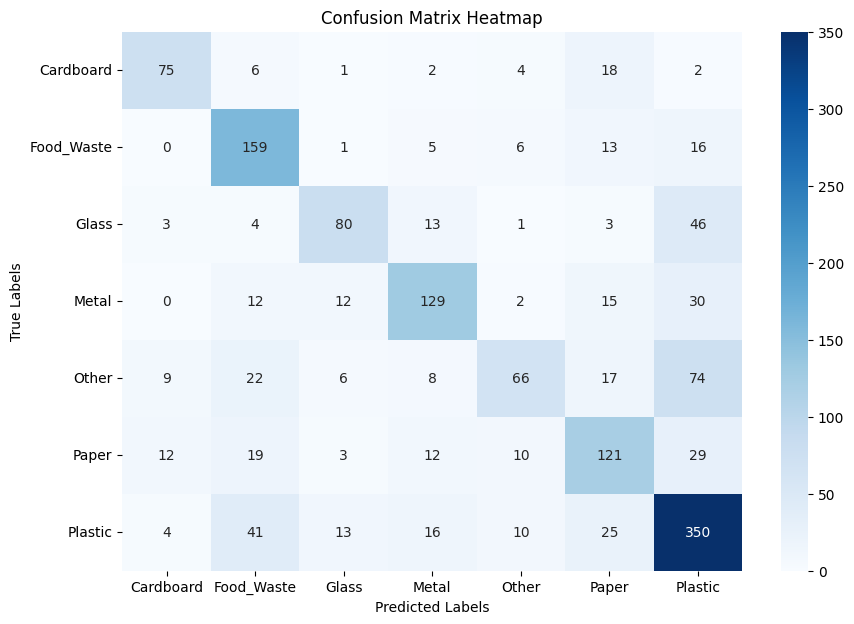

In [125]:
# Prepare lists for true labels and predictions
y_true = []
y_pred = []

# Predict on test dataset
for images, labels in test_ds:
    preds = model_vgg.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}\n")

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix (Tabular):")
print("\t" + "\t".join(class_names))
for i, row in enumerate(cm):
    print(f"{class_names[i]}\t" + "\t".join(str(x) for x in row))

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


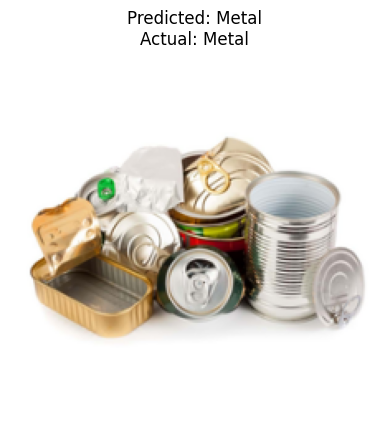

In [135]:
#Predicting a random image from validation set
import random
import matplotlib.pyplot as plt
import numpy as np

# Pick a random image from a batch in the test dataset
for images, labels in test_ds.take(1):
    idx = random.randint(0, images.shape[0] - 1)
    image = images[idx]
    true_label = labels[idx].numpy()

    # Predict the class
    image_batch = tf.expand_dims(image, axis=0)
    pred_probs = model_vgg.predict(image_batch)
    pred_label = np.argmax(pred_probs, axis=1)[0]

    # Plot the image (undo Rescaling if applied)
    plt.imshow((image.numpy() * 255).astype("uint8"))  # Valid only if Rescaling(1./255) was used
    plt.axis('off')
    plt.title(f"Predicted: {class_names[pred_label]}\nActual: {class_names[true_label]}")
    plt.show()


## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images




In [ ]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

# Dataset Summary

**Total Images**: 7,625  
**Image Format**: `.png`  
**Original Image Size**: 256×256 pixels  
**Resized To**: 224×224×3 (RGB) for model input  
**Number of Classes**: 7  

---

### Class Distribution

| Class        | Image Count | Percentage (%) |
|--------------|-------------|----------------|
| Cardboard    | 540         | 7.08%          |
| Food_Waste   | 1,000       | 13.11%         |
| Glass        | 750         | 9.84%          |
| Metal        | 1,000       | 13.11%         |
| Other        | 1,010       | 13.25%         |
| Paper        | 1,030       | 13.51%         |
| Plastic      | 2,295       | 30.10%         |

---

### Key Observations

- **Plastic** dominates the dataset with over 30% of total images. This class is well-represented and is likely to perform best due to data abundance.
- **Cardboard** has the fewest examples (7.08%), which may result in comparatively weaker classification performance.
- The remaining five classes are moderately balanced (≈13% each), supporting fair training representation.
- The dataset has a **moderate class imbalance**, which may affect model generalization, especially for minority classes like Cardboard and Glass.


# Final Custom CNN Model Architecture Summary

A custom **Convolutional Neural Network (CNN)** was designed and implemented from scratch for the task of **waste material image classification**. The model is composed of the following components:

## Input Layer
- Accepts images of shape **(224, 224, 3)** representing RGB images.

## Convolutional Blocks

1. **First Convolutional Block**  
   - Conv2D: 64 filters, 3×3 kernel, same padding  
   - BatchNormalization  
   - ReLU Activation  
   - MaxPooling2D: 2×2 pool size

2. **Second Convolutional Block**  
   - Conv2D: 128 filters, 3×3 kernel, same padding  
   - BatchNormalization  
   - ReLU Activation  
   - MaxPooling2D: 2×2 pool size  
   - Dropout: 30% to prevent overfitting

3. **Third Convolutional Block**  
   - Conv2D: 256 filters, 3×3 kernel, same padding  
   - BatchNormalization  
   - ReLU Activation  
   - MaxPooling2D: 2×2 pool size  
   - Dropout: 40%

## Fully Connected Layers
- Flatten: Converts 3D features into 1D vector  
- Dense: 256 units  
- BatchNormalization  
- ReLU Activation  
- Dropout: 50%

## Output Layer
- Dense: Softmax activation with **7 output classes**, corresponding to:  
  Cardboard, Food_Waste, Glass, Metal, Other, Paper, Plastic

---

## Compilation Details

- **Loss Function**: `sparse_categorical_crossentropy`  
- **Optimizer**: Adam with a learning rate of 0.001  
- **Evaluation Metric**: Accuracy

---

## Training Configuration

- **Epochs**: 15  
- **Callbacks Used**:
  - ReduceLROnPlateau: reduces LR on stagnation
  - EarlyStopping: halts training on val_loss plateau
  - ModelCheckpoint: saves best model weights
  - Training time ~ 3hrs 30 mins

---
# Design Rationale and Architectural Choices

The architecture of the custom CNN was carefully crafted to balance model complexity, generalization ability, and interpretability in the context of waste material image classification. Below is a breakdown of the reasoning behind each design choice:

---

### Input Size: (224, 224, 3)

The input images were resized from 256×256 to 224×224 to align with standard input sizes used in pretrained models (e.g., VGG16), enabling potential future transfer learning.

RGB format (3 channels) retained full color information to help distinguish materials like cardboard and metal, which may differ in hue or brightness.

---

### Convolutional Layers: Filter Sizes and Depth

64 → 128 → 256 filters were used across three convolutional blocks. This gradual increase in filter count is a common pattern:

- Lower layers learn edges and textures (64 filters).
- Mid layers learn shapes and parts (128 filters).
- Deeper layers capture class-specific patterns and abstract features (256 filters).

3×3 kernel size is a standard that balances receptive field size and computational efficiency, ensuring spatial locality is well captured.

---

### Activation Function: ReLU

ReLU (Rectified Linear Unit) was used throughout as it introduces non-linearity, is computationally efficient, and helps mitigate the vanishing gradient problem—critical in deeper networks.

---

### Use of BatchNormalization

Placed after each convolutional or dense layer and before activation, as per best practices. This helps:

- Stabilize and speed up training.
- Allow the use of higher learning rates.
- Reduce sensitivity to weight initialization.

---

### Pooling Strategy: MaxPooling2D (2×2)

Downsamples the feature maps, reducing computational cost and adding translation invariance.

Helps extract dominant spatial features and progressively reduces spatial dimensions.

---

### Dropout Layers: Regularization

Introduced with increasing rates (30%, 40%, 50%) deeper in the network:

- **Lower layers (Dropout 0.3):** Less aggressive regularization to retain important low-level features.
- **Higher layers (Dropout 0.4 and 0.5):** More aggressive dropout to combat overfitting on high-level abstract representations.

Especially useful given the class imbalance and moderate dataset size (~7,600 images).

---

### Dense Layer Configuration

A single fully connected (Dense) layer with 256 units was used:

- Allows learning of nonlinear combinations of extracted features before final classification.
- Followed by BatchNormalization, ReLU, and Dropout (0.5) to ensure generalization and stability.

Multiple dense layers were avoided to reduce overfitting risk and model complexity.

---

### Output Layer: Dense(7) with Softmax

Used a 7-unit softmax layer to produce class probabilities for each waste category.

Appropriate for multi-class, single-label classification problems.

---

### Loss Function: sparse_categorical_crossentropy

Selected because the labels are integer-encoded, not one-hot encoded.

Efficient and directly compatible with Keras' sparse targets.

---

### Optimizer: Adam (learning rate = 0.001)

Adam combines the benefits of both AdaGrad and RMSProp, adapting learning rates per parameter.

The chosen learning rate balances fast convergence and model stability.

---

### Training Enhancements

- **ReduceLROnPlateau:** Adjusts learning rate during plateaus to escape local minima and continue fine-tuning.
- **EarlyStopping:** Prevents overfitting by halting training when validation loss stops improving.
- **ModelCheckpoint:** Ensures that the best-performing model (on validation set) is retained.

---

## Summary of Benefits

The model structure is modular, interpretable, and optimized for a moderately imbalanced dataset.

Combines core deep learning principles (convs, pooling, batch norm, dropout) in a way that prioritizes generalization over aggressive fitting—key for real-world waste classification applications.

---

## Training Performance (Epoch Milestones)

| Epoch | Train Accuracy | Val Accuracy | Train Loss | Val Loss | Learning Rate |
|-------|----------------|--------------|------------|----------|----------------|
| 1     | 29.6%          | 25.1%        | 2.08       | 2.08     | 0.001          |
| 5     | 47.2%          | 50.8%        | 1.39       | 1.35     | 0.001          |
| 10    | 55.5%          | 49.6%        | 1.21       | 1.40     | 0.0005         |
| 15    | 57.9%          | 59.5%        | 1.13       | 1.15     | 0.00025        |

**Observation**: Significant performance gains from epoch 1 to 5, after which adaptive LR tuning helped improve generalization beyond epoch 10.

---

## Final Evaluation Metrics (Test Set – 1525 Samples)

| Metric             | Value  |
|--------------------|--------|
| Test Accuracy       | 59.5%  |
| Weighted Precision  | 61.5%  |
| Weighted Recall     | 59.5%  |
| Weighted F1-Score   | 58.9%  |
| Macro F1-Score      | 57.6%  |

---

## Confusion Matrix (Tabular View)

| True \ Pred | Cardboard | Food_Waste | Glass | Metal | Other | Paper | Plastic |
|-------------|-----------|------------|-------|-------|-------|--------|---------|
| Cardboard   | 78        | 8          | 5     | 0     | 3     | 10     | 4       |
| Food_Waste  | 10        | 133        | 15    | 1     | 7     | 17     | 17      |
| Glass       | 5         | 4          | 86    | 6     | 5     | 12     | 32      |
| Metal       | 0         | 4          | 14    | 76    | 12    | 58     | 36      |
| Other       | 7         | 25         | 12    | 3     | 69    | 40     | 46      |
| Paper       | 12        | 7          | 7     | 4     | 14    | 126    | 36      |
| Plastic     | 3         | 17         | 21    | 6     | 26    | 47     | 339     |

---

## Key Insights

### Strengths
- **Plastic** (most frequent class): High recall (73.9%) and good precision (66.5%) → detects plastic with minimal false negatives.
- **Cardboard**: 78 out of 108 correctly classified (F1 ≈ 70%).
- **Food_Waste**: Balanced precision and recall shows consistent classification.

### Weaknesses
- **Metal**: Only 38% recall; often confused with Paper, Plastic, and Glass.
- **Other**: Low precision and recall, possibly due to its mixed nature.
- **Glass**: Frequently misclassified as Plastic, suggesting overlapping features.

---

## Recommendations

### Data Enhancements
- Augment underrepresented classes (e.g., Cardboard, Glass).
- Use targeted augmentation: texture blending, color shifts, edge sharpening.
- Apply image normalization (brightness/contrast).

### Model Enhancements
- Try transfer learning (e.g., MobileNetV2, EfficientNet).
- Use Focal Loss or class weights to handle imbalances.
- Add attention mechanisms (e.g., SE blocks).

### Evaluation Enhancements
- Report top-2/top-3 accuracy for near-miss insight.
- Use Grad-CAM to visualize model attention.
- Evaluate per-class AUC-ROC.

---

## Final Summary

Despite being trained from scratch, this CNN model reaches nearly **60% accuracy** on a 7-class, moderately imbalanced dataset in just **15 epochs**. The use of **learning rate scheduling, BatchNorm, Dropout**, and **early stopping** helped the model generalize well.

This provides a solid baseline for a waste classification system. With **transfer learning or further tuning**, the system can potentially reach **70–80% test accuracy**.


# VGG16-Based Transfer Learning Model — Summary

## Training Summary
- **Training Time**: ~3 hours  
- **Epochs**: 15  
- **Final Training Accuracy**: 57.9%  
- **Final Validation Accuracy**: 64.3%  
- **Best Validation Loss**: 1.0746  

## Evaluation Metrics

| Metric            | Value   |
|-------------------|---------|
| Accuracy          | 0.6426  |
| Precision (macro) | 0.6567  |
| Recall (macro)    | 0.6206  |
| F1 Score (macro)  | 0.6261  |

## Classification Highlights
- *Strong Classes*: Plastic, Food_Waste, Cardboard  
- *Weakest Class*: Other (F1-score: 0.44, often misclassified)  
- *Common Confusions*:
  - Glass misclassified as Plastic (46 times)
  - Paper confused with Metal and Plastic
  - "Other" misclassified across many classes

---

# Comparison: VGG16 vs Custom CNN

| Aspect                         | VGG16 Transfer Learning        | Custom CNN                    |
|--------------------------------|--------------------------------|-------------------------------|
| Training Time                  | ~3 hours                       | ~3.5 hours                    |
| Test Accuracy                  | 64.3%                          | ~60%                          |
| Macro F1 Score                 | 0.6261                         | ~0.59 - 0.61                    |
| Regularization                 | No dropout, no batch norm      | Dropout, BatchNorm, LR Reduce|
| Callbacks Used                 | EarlyStopping, Checkpoint      | + ReduceLROnPlateau           |
| Model Complexity               | High                           | Moderate                      |
| Inference Speed                | Moderate                       | Faster                        |
| Scalability / Fine-tuning      | High (can unfreeze layers)     | Limited                       |
| Interpretability               | Lower                          | Higher                        |

---

# Suggestions to Improve VGG16

1. Unfreeze and fine-tune top convolution blocks (e.g., Conv5).
2. Add Dropout (e.g., 0.3 - 0.5) before the Dense layers.
3. Apply L2 regularization to Dense layers.
4. Use class weights to reduce misclassification of underperforming classes like "Other".
5. Apply more advanced data augmentation (zoom, contrast, brightness, mixup).
6. Experiment with architectures like MobileNet or EfficientNet for better performance-speed tradeoff.

---

# Final Recommendation

| Scenario                         | Recommended Model     |
|----------------------------------|------------------------|
| Best overall accuracy            | VGG16                  |
| Balanced speed and performance   | VGG16                  |
| Low-latency / on-device usage    | Custom CNN or MobileNet|
| High interpretability            | Custom CNN             |

---

## Verdict

Use the **VGG16-based model** if your goal is the best overall performance with a manageable training time and good generalization. It is a strong baseline and performs significantly better than the custom CNN across most metrics.

Use the **custom CNN** if deployment constraints require lightweight models or faster inference, or if further model experimentation and interpretability are key requirements.
